In [34]:
from sortedcontainers import SortedList
from math import log, exp, sqrt
from random import random, randrange
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from time import time
matplotlib.rcParams['text.usetex'] = True

In [2]:
# NOTE ON BIT MANIPULATION: 1 << i = 2^i

# DESCRIPTION: Builds the rejection sampling envelope for the distribution proportional to exp(-η*L)
# INPUT: 
#     sl = SortedList datastructure, storing the current loss estimates (L[arm], arm)
#     logK = log_2(number of arms), assuming that the number of arms is a power of two
#     η = stepsize
# OUTPUT: envelope q of length logK, where intuitively q[i] = \tilde{p}[2^i - 1]
def build_envelope(sl, logK, η):
    return [exp(-η*sl[(1 << i)-1][0]) for i in range(logK)]

# returns an arm using rejection sampling
# example to keep in mind:
# \tilde{p} = (8, 7, 6, 5, 4, 3, 2, 1)
# \tilde{q} = (8, 8, 7, 7, 5, 5, 5, 5)
# bucket    = (0____ 1____ 2_________)
# q         = (8,    7,    5) 


# DESCRIPTION: Samples from exp(-η*L) using the proposal q. Returns (L[arm], arm) pair
# INPUT: 
#     q = rejection sampling envelope built by build_envelope()
#     sl = SortedList datastructure, storing the current loss estimates (L[arm], arm)
#     η = stepsize
def sample(q, sl, η):
    logK = len(q)
    
    # Compute normalizing constant of q
    Z = 2.0*q[0]
    for i in range(1, logK):
        Z += q[i]*(1 << i)
        
    # Rejection while loop
    counter = 0
    while True:
        counter += 1
        # First we draw a random bucket
        u = random()
        bucket = -1
        cdf = 2*q[0]
        if u < cdf/Z:
            bucket = 0
        if bucket < 0:
            for i in range(1, logK):
                cdf += q[i]*(1 << i)
                if u < cdf/Z:
                    bucket = i
                    break
        if bucket < 0:
            print("Error: bucket not assigned")
            return 

        # We draw the arm uniformly within the bucket. Draw = k means we drew the k-th largest arm
        if bucket == 0:
            draw = randrange(2)
        else:
            draw = (1 << bucket) + randrange(1 << bucket)
            
        # Rejection step
        if random() < exp(-η*sl[draw][0])/q[bucket]:
            return sl[draw]
        
        
# DESCRIPTION: Returns (x,q(x)) where x is a sample from q and q(x) is the (normalized) density of point x
# INPUT: 
#     q = upper envelope constructed by build_envelope()
def sample_envelope(q):
    logK = len(q)
    
    # Compute normalizing constant of q
    Z = 2.0*q[0]
    for i in range(1, logK):
        Z += q[i]*(1 << i)
        
    # First we draw a random bucket
    u = random()
    bucket = -1
    cdf = 2*q[0]
    if u < cdf/Z:
        bucket = 0
    if bucket < 0:
        for i in range(1, logK):
            cdf += q[i]*(1 << i)
            if u < cdf/Z:
                bucket = i
                break
    if bucket < 0:
        print("Error: bucket not assigned")
        return 

    # We draw the arm uniformly within the bucket. Draw = k means we drew the k-th largest arm
    if bucket == 0:
        draw = randrange(2)
    else:
        draw = (1 << bucket) + randrange(1 << bucket)
    return draw, q[bucket]/Z

In [61]:
# DESCRIPTION: Performs one step of the modified EXP3 algorithm and returns loss incurred
# INPUT: 
#     sl = SortedList datastructure, storing the current loss estimates (L[arm], arm)
#     η = stepsize
#     losstype = type of loss to be used
def mod_EXP3(sl, η, losstype):
    
    # BUILDING ENVELOPE
    q = build_envelope(sl, logK, η)
    
    # SAMPLING ARM
    L, arm = sample(q, sl, η)
    
    # OBSERVING LOSS
    loss = losstype.observe_loss(arm)
    
    # J is not the true index, but indexed according to the sorted order
    temp = 0
    m = 5
    for i in range(m):
        J, q_prob = sample_envelope(q)
        temp += exp(-η*sl[J][0])/q_prob
    temp /= float(m)
    dL = loss/exp(-η*L) * temp
    
    # UPDATING SORTED ARRAY
    sl.remove((L, arm))
    sl.add((L+dL, arm))
    return loss

# DESCRIPTION: Performs one step of EXP3 and returns (l,s) where l is the loss incurred and s = sum(L)
# INPUT:
#     L = current loss vector
#     p = normalized probability vector proportional to exp(-η*L)
#     s = normalizing constant; equal to sum of the vector exp(-η*L)
#     η = step size
#     logK = log_2(number of arms)
#     losstype = type of loss to be used
def EXP3(L, p, s, η, logK, losstype):
    # Sampling the arm
    arm = np.random.choice(range(1 << logK), 1, p = p)[0]
    
    # Observing the loss
    loss = losstype.observe_loss(arm)
    
    # Updating the normalizing constant and loss vector
    s -= exp(-η*L[arm])
    L[arm] += loss/p[arm]
    s += exp(-η*L[arm])
    
    # Updating the normalized probability vector
    for i in range(1 << logK):
        p[i] = exp(-η*L[i])/s
    return loss, s

In [4]:
# Below are the definitions of the three types of losses used. 

class cliff:
    def __init__(self, logK, frac):
        self.logK = logK
        self.frac = frac
        
    def observe_loss(self, arm):
        return 0 if arm < (1 << self.logK)*self.frac else 1
        
class changingCliff:
    def __init__(self, logK, mult, T):
        self.logK = logK
        self.mult = mult
        self.T = T
        self.t = None
        
    def observe_loss(self, arm):
        bucket = int(self.t*self.mult/float(self.T))
        if bucket*(1 << self.logK)/float(self.mult) <= arm <= (bucket + 1)*(1 << self.logK)/float(self.mult):
            return 0
        return 1

class stochastic:
    def __init__(self, logK):
        self.logK = logK
        
    def observe_loss(self, arm):
        return min(1,max(0,arm/float(1<<self.logK) - 0.3*random()))

# Comparing iteration speed

In [11]:
T = 10000

# Setting loss parameters
frac = 0.1
mult = 5

logKs = range(2,26)
times = np.zeros((len(logKs), 2))

In [12]:
# Setting up the self balancing binary search tree
sl = SortedList()

# Running mod_EXP3
for j in range(len(logKs)):
    logK = logKs[j]
    losstype = changingCliff(logK, mult, T)
    
    # Monitoring progress
    print("\r", str(int(100*float(j+1)/len(logKs)))+"%", end="")
    
    η = sqrt(2*logK/float(T*(1 << logK)))
    
    # Initializing the binary search tree
    sl.clear()
    sl.update([(0,i) for i in range(1 << logK)])
    
    start = time()
    for t in range(T):
        losstype.t = t
        _ = mod_EXP3(sl, η, losstype)
    times[j,0] = time()-start
    
print()

# Running EXP3, note we decrease T and extrapolate because otherwise takes forever
T = 100
for j in range(len(logKs)):
    # Monitoring progress
    print("\r", str(int(100*float(j+1)/len(logKs)))+"%", end="")
    
    logK = logKs[j]
    losstype = changingCliff(logK, mult, T)
    
    η = sqrt(2*logK/float(T*(1 << logK)))
    
    # For too many arms skip simulation
    if logK > 20:
        times[j, 1] = np.NaN
        continue
        
    # Setup for EXP3
    L = [0.0]*(1 << logK)
    p = [1/float(1 << logK)]*(1 << logK)
    s = float(1 << logK) 
                 
    start = time()
    for t in range(T):
        losstype.t = t
        _, s = EXP3(L, p, s, η, logK, losstype)
    times[j,1] = 100*(time()-start)

 100%
 100%

(0.0, 10.0)

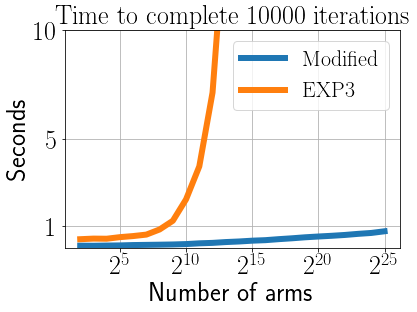

In [13]:
plt.plot(logKs, times, linewidth=6)
plt.title(r"$\textrm{Time to complete 10000 iterations}$", size=26)
plt.legend([r'$\textrm{Modified}$', r'$\textrm{EXP3}$'], fontsize=22)
plt.xlabel("Number of arms", size=26)
plt.ylabel('Seconds', size=26)
plt.yticks(ticks=[1,5, 10], size=26)
plt.xticks(ticks=[5, 10, 15, 20, 25], labels=[r"$2^5$", r"$2^{10}$", r"$2^{15}$", r"$2^{20}$", r"$2^{25}$"], size=26)
plt.grid(b=True)
plt.ylim(0,10)

In [ ]:
plt.savefig('./figures/speed_comparison.jpg')

# Comparing regret

In [114]:
logK = 8
T = 20000
losses = [changingCliff(logK, 5, T), stochastic(logK), cliff(logK, 0.1)]

ηs = [1]

In [115]:
ave = np.zeros((3, T, 2, len(ηs)))
stds = np.zeros((3, T, 2, len(ηs)))

for η_i, η_mult in enumerate(ηs):
    for i, losstype in enumerate(losses):
        nExp = 20
        regret = np.zeros((T, 2, nExp))

        for k in range(nExp):
            print("\r", str(int(100*float(k+1)/nExp))+"%", end="")

            # Setup for modified EXP3
            sl.clear()
            sl.update([(0,l) for l in range(1 << logK)])
            q = [None]*logK
            L = np.zeros(1 << logK)

            for t in range(T):
                losstype.t = t
                η = η_mult*sqrt(logK/((t+1)*2**logK))

            #     Modified Exp3
                tmp = mod_EXP3(sl, η, losstype)
                regret[t,0,k] = tmp + (0 if t==0 else regret[t-1,0,k])

            #     Exp3
                s = np.sum([exp(-η* l) for l in L])
                p = [exp(-η*l)/s for l in L]
                regret[t,1,k], _ = EXP3(L, p, s, η, logK, losstype)
                regret[t,1,k] += (0 if t==0 else regret[t-1,1,k])

        for j in range(T):
            ave[i,j,0,η_i] = np.mean(regret[j,0,:])
            ave[i,j,1, η_i] = np.mean(regret[j,1,:])
            stds[i,j,0, η_i] = 4*np.std(regret[j,0,:])
            stds[i,j,1, η_i] = 4*np.std(regret[j,1,:])    

 100%

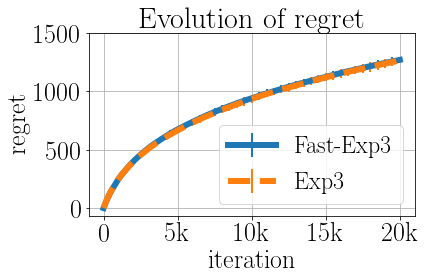

In [116]:
for η_i in range(len(ηs)):
    plt.errorbar(x=range(T), y=ave[1,:,0,η_i], linewidth=6, elinewidth=2, errorevery=500, yerr = stds[1,:,0,η_i])
    plt.errorbar(x=range(T), y=ave[1,:,1,η_i], linewidth=6, elinewidth=2, errorevery=500, yerr = stds[1,:,1,η_i], linestyle='dashed')
    plt.legend([r'\textrm{Fast-Exp3}', r'\textrm{Exp3}'], fontsize=24)
    
plt.title(r"\textrm{Evolution of regret}", size=30)
plt.xlabel(r"\textrm{iteration}", size=26)
plt.ylabel(r'\textrm{regret}', size=26)
plt.yticks(ticks=[0,500,1000,1500], labels=[r"$0$", r"$500$", r"$1000$", r"$1500$"], size=26)
plt.xticks(ticks=[0,5000,10000,15000, 20000], labels=[r"$0$", r"$5\textrm{k}$", r"$10\textrm{k}$", r"$15\textrm{k}$", r"$20\textrm{k}$"], size=26)
plt.grid(b=True)
plt.tight_layout()
plt.savefig('./figures/EXP3_stochastic.jpg')
# plt.ylim(0,10)
plt.show()

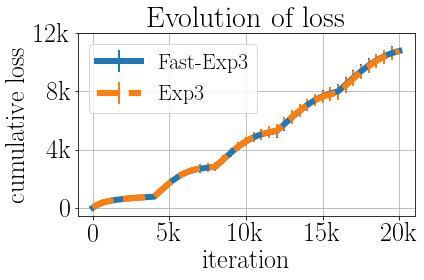

In [117]:
for η_i in range(len(ηs)):
    plt.errorbar(x=range(T), y=ave[0, :,0, η_i], linewidth=6, elinewidth=2, errorevery=500, yerr = stds[0, :,0, η_i])
    plt.errorbar(x=range(T), y=ave[0, :,1, η_i], linewidth=6, elinewidth=2, errorevery=500, yerr = stds[0, :,0, η_i], linestyle='dashed')
plt.title(r"\textrm{Evolution of loss}", size=30)
plt.legend([r'\textrm{Fast-Exp3}', r'\textrm{Exp3}'], fontsize=22)
plt.xlabel(r"\textrm{iteration}", size=26)
plt.ylabel(r'\textrm{cumulative loss}', size=26)
plt.yticks(ticks=[0,4000, 8000, 12000], labels=[r"$0$", r"$4\textrm{k}$", r"$8\textrm{k}$", r"$12\textrm{k}$"], size=26)
plt.xticks(ticks=[0,5000,10000,15000, 20000], labels=[r"$0$", r"$5\textrm{k}$", r"$10\textrm{k}$", r"$15\textrm{k}$", r"$20\textrm{k}$"], size=26)
plt.grid(b=True)
plt.tight_layout()
plt.savefig('./figures/EXP3_changing_cliff.jpg')
# plt.ylim(0,10)
plt.show()

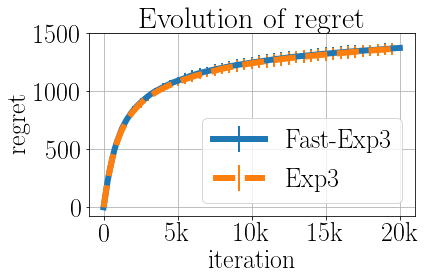

In [118]:
for η_i in range(len(ηs)):
    plt.errorbar(x=range(T), y=ave[2, :,0, η_i], linewidth=6, elinewidth=2, errorevery=500, yerr = stds[2, :,0, η_i])
    plt.errorbar(x=range(T), y=ave[2, :,1, η_i], linewidth=6, elinewidth=2, errorevery=500, yerr = stds[2, :,0, η_i], linestyle='dashed')
plt.title(r"\textrm{Evolution of regret}", size=30)
plt.legend([r'\textrm{Fast-Exp3}', r'\textrm{Exp3}'], fontsize=26)
plt.xlabel(r"\textrm{iteration}", size=26)
plt.ylabel(r'\textrm{regret}', size=26)
plt.yticks(ticks=[0,500, 1000, 1500], labels=[r"$0$", r"$500$", r"$1000$", r"$1500$"], size=26)
plt.xticks(ticks=[0,5000,10000,15000, 20000], labels=[r"$0$", r"$5\textrm{k}$", r"$10\textrm{k}$", r"$15\textrm{k}$", r"$20\textrm{k}$"], size=26)
plt.grid(b=True)
plt.tight_layout()
plt.savefig('./figures/EXP3_cliff.jpg')
# plt.ylim(0,10)
plt.show()